# Joe Stanley
#### ECE522 - HWK6

## Problem:
Plot torque for time equal to 0 to 0.16 seconds for a three-phase short circuit on the machine of S22b handout.
Use the complete not the approximate solution.

In [2]:
# Import Basic Libraries
import numpy as np
import matplotlib.pyplot as plt
import electricpy as ep # Joe Stanley's Module, docs @: http://engineerjoe440.github.io/electricpy/

In [21]:
# Define Time Array
time = np.linspace(0,0.16,1000)

# Define Machine Parameters
rs = 0.018
Lls = 0.1
Llr = 0.1
rr = 0.02
rho = 4
Lm = 2.0

# Define Calculated Machine Parameters
Ls = Lls + Lm
Lr = Llr + Lm

# Define ABC Base Parameters
Sbase = ep.hp_to_watts(100)
Vbase = 480
Ibase = ep.ipu(Sbase,VLL=Vbase)
Zbase = ep.zpu(Sbase,VLL=Vbase)
webase = 2*np.pi*60
Lbase = Zbase/webase
wmbase = webase/(rho/2)
tqbase = Sbase/wmbase

# Define QD Base Parameters
Idqbase = np.sqrt(2)*Ibase
Vdqbase = np.sqrt(2/3)*Vbase

# Define Machine Transient Parameters
tqs = Ls / (webase*rs)
tqr = Lr / (webase*rr)
alpha = tqr/tqs
phi = 1 - (Lm**2)/(Ls*Lr)
tqsp = phi*tqs
tqrp = phi*tqr

# Define Eigenvalues
wr = webase
wrf = 0

In [51]:
# Define Induction Machine Eigenvalue Calculator
def imeigenvalues(Lr,Ls,Lm,Rr,Rs,wrf=0,freq=60):
    """
    Induction Machine Eigenvalue Calculator
    
    Calculates the pertinent eigenvalues for an unloaded
    induction machine given a specific set of machine
    parameters.
    
    Parameters
    ----------
    Lr:         float
                Inductance of the Rotor (in Henrys).
    Ls:         float
                Inductance of the Stator (in Henrys).
    Lm:         float
                Inductance of the Magnetizing branch
                (in Henrys).
    Rr:         float
                Resistance of the Rotor (in Ohms).
    Rs:         float
                Resistance of the Stator (in Ohms).
    wrf:        float, optional
                Frequency (in radians/sec) of the rotor slip. **** Is this correct? I can't recall now... ****
                default=0
    freq:       float, optional
                Base frequency of the system (in Hertz).
                default=60
    
    Returns
    -------
    lam1:       complex
                The First Eigenvalue
    lam2:       complex
                The Second Eigenvalue
    """
    # Calculate Required Values
    omega_e_base = 2*np.pi*freq
    omega_rf = wrf
    torque_s = Ls/(omega_e_base*Rs)
    torque_r = Lr/(omega_e_base*Rr)
    alpha = torque_r / torque_s
    phi = 1 - Lm**2/(Ls*Lr)
    omega_r = omega_e_base
    # Calculate k1
    k1 = -1/(2*phi*torque_r)*(1+alpha)
    k1 += 1j*(omega_r/2-omega_rf)
    # Calculate k2
    k2 = 1/(2*phi*torque_r)
    k2 *= np.sqrt((1+alpha)**2-4*phi*alpha-(omega_r*phi*torque_r)**2
                 +2j*(alpha-1)*omega_r*phi*torque_r)
    # Evaluate Eigenvalues and Return
    lam1 = k1+k2
    lam2 = k1-k2
    return(lam1,lam2)

# Define IM 3-Phase SC Current Calculator
def imphs3sc(t,Is0,Lr,Ls,Lm,Rr,Rs,wrf=0,freq=60,real=True):
    """
    Induction Machine 3-Phase SC Calculator
    
    Determines the short-circuit current at
    a specified time for a three-phase fault
    on an unloaded induction machine.
    
    Parameters
    ----------
    t:          array_like
                The time at which to find the
                current, may be int, float, or
                numpy array.
    Is0:        complex
                The initial (t=0) current on
                the stator.
    Lr:         float
                Inductance of the Rotor (in Henrys).
    Ls:         float
                Inductance of the Stator (in Henrys).
    Lm:         float
                Inductance of the Magnetizing branch
                (in Henrys).
    Rr:         float
                Resistance of the Rotor (in Ohms).
    Rs:         float
                Resistance of the Stator (in Ohms).
    wrf:        float, optional
                Frequency (in radians/sec) of the rotor slip. **** Is this correct? I can't recall now... ****
                default=0
    freq:       float, optional
                Base frequency of the system (in Hertz).
                default=60
    real:       bool, optional
                Control argument to force returned value
                to be real part only. default=True
    
    Returns
    -------
    ias:        array_like
                Fault Current
    """
    # Calculate Required Values
    omega_r = 2*np.pi*freq
    torque_s = Ls/(omega_r*Rs)
    phi = 1 - Lm**2/(Ls*Lr)
    # Calculate Eigenvalues
    lam1, lam2 = imeigenvalues(Lr,Ls,Lm,Rr,Rs,wrf,freq)
    # Calculate pIs0
    pIs0 = -(1/(phi*torque_s)+1j*(1-phi)/phi*omega_r)*Is0
    # Calculate Constants
    C1 = (lam2*Is0-pIs0)/(lam2-lam1)
    C2 = (pIs0-lam1*Is0)/(lam2-lam1)
    # Calculate ias and Return
    ias = C1*np.exp(lam1*t)+C2*np.exp(lam2*t)
    if real:
        ias = np.real(ias)
    return(ias)

# Define IM Torque Calculation
def imphs3sctorq(t,Is0,Lr,Ls,Lm,Rr,Rs,wrf=0,freq=60):
    """
    Parameters
    ----------
    t:          array_like
                The time at which to find the
                current, may be int, float, or
                numpy array.
    Is0:        complex
                The initial (t=0) current on
                the stator.
    Lr:         float
                Inductance of the Rotor (in Henrys).
    Ls:         float
                Inductance of the Stator (in Henrys).
    Lm:         float
                Inductance of the Magnetizing branch
                (in Henrys).
    Rr:         float
                Resistance of the Rotor (in Ohms).
    Rs:         float
                Resistance of the Stator (in Ohms).
    p:          int
                Number of electrical poles.
    wrf:        float, optional
                Frequency (in radians/sec) of the rotor slip. **** Is this correct? I can't recall now... ****
                default=0
    freq:       float, optional
                Base frequency of the system (in Hertz).
                default=60
    
    Returns
    -------
    Tem:        array_like
                Induction machine torque in N*m
    """
    # Calculate Required Values
    omega_r = 2*np.pi*freq
    torque_s = Ls/(omega_r*Rs)
    phi = 1 - Lm**2/(Ls*Lr)
    # Calculate Eigenvalues
    lam1, lam2 = imeigenvalues(Lr,Ls,Lm,Rr,Rs,wrf,freq)
    # Calculate pIs0
    pIs0 = -(1/(phi*torque_s)+1j*(1-phi)/phi*omega_r)*Is0
    # Calculate Constants
    C1 = (lam2*Is0-pIs0)/(lam2-lam1)
    C2 = (pIs0-lam1*Is0)/(lam2-lam1)
    # Calculate ias and Return
    idqs = C1*np.exp(lam1*t)+C2*np.exp(lam2*t)
    idqr = C2*np.exp(lam1*t)+C1*np.exp(lam2*t)
    # Calculate Lambda
    lamdqr = Lm*idqs+Lr*idqr
    # Calculate Torque
    Tem = Lm/Lr * (lamdqr.real*idqs.imag - lamdqr.imag*idqs.real)
    return(Tem)

λ1: (-34.723+3.257j) 		λ2: (-38.653+373.734j)
Is (0°): 0.476 ∠ -89.509°
Is (90°): 0.476 ∠ 0.491°


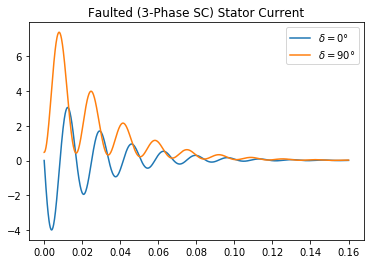

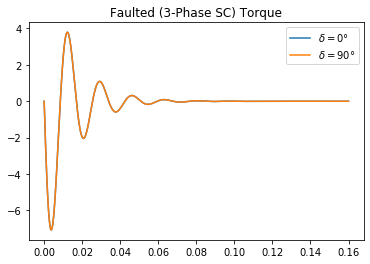

In [54]:
# Calculate Eigenvalues from New Function
lam1, lam2 = imeigenvalues(Lr,Ls,Lm,rr,rs) # Leave wrf and freq at defaults
print("λ1:",np.around(lam1,3),"\t\tλ2:",np.around(lam2,3))

# Define Source Voltage
Vs0 = ep.phasor(1,0)
Vs90 = ep.phasor(1,90)

# Calculate Stator Current at t=0 for both Cases
Is0 = Vs0/(rs+1j*Ls)
ep.cprint(Is0,label="Is (0°):")
Is90 = Vs90/(rs+1j*Ls)
ep.cprint(Is90,label="Is (90°):")

# Calculate ias over time
ias0 = imphs3sc(time,Is0,Lr,Ls,Lm,rr,rs)
ias90 = imphs3sc(time,Is90,Lr,Ls,Lm,rr,rs)

# Plot
plt.plot(time,ias0,label="$\delta=0°$")
plt.plot(time,ias90,label="$\delta=90°$")
plt.title("Faulted (3-Phase SC) Stator Current")
plt.legend()
plt.show()

# Calculate Torque over Time
Tq0 = imphs3sctorq(time,Is0,Lr,Ls,Lm,rr,rs)
Tq90 = imphs3sctorq(time,Is90,Lr,Ls,Lm,rr,rs)

# Plot
plt.plot(time,Tq0,label="$\delta=0°$")
plt.plot(time,Tq90,label="$\delta=90°$")
plt.title("Faulted (3-Phase SC) Torque")
plt.legend()
plt.show()